```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [34]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Boknafjorden

In [35]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [36]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

In [37]:
%cuda_context_handler barotropic_gpu_ctx

In [38]:
%cuda_context_handler baroclinic_gpu_ctx

In [39]:
%cuda_context_handler drifter_gpu_ctx

Path to the test file

In [40]:
source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"

## Inspecting file structure and content

In [41]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [42]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 801, xi_rho: 1161, eta_u: 801, xi_u: 1160, eta_v: 800, xi_v: 1161)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

## Generating GPUOcean Simulation from Input

General parameters

In [44]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 685, dimX-360, 335, dimY-330

Simulation span: 6h!

In [45]:
t_start = 10
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

### Initial conditions

In [46]:
mld_density = 1023
sponge_cells = {'north': 5, 'south': 5, 'east': 5, 'west': 5}
ref_barotropic_data_args, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, mld_density, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False, sponge_cells=sponge_cells)

#### Barotropic Simulations

In [47]:
ref_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


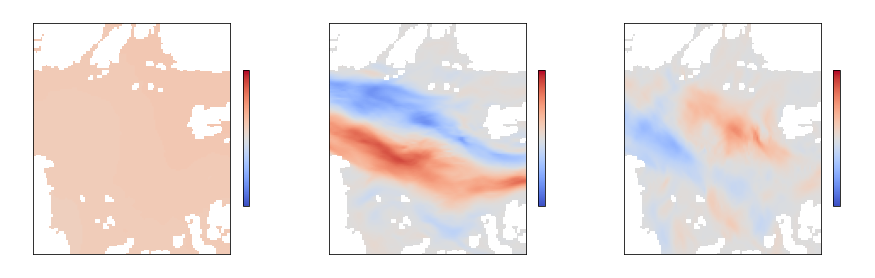

In [48]:
bt_eta, bt_hu, bt_hv = ref_barotropic_sim.download()

fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(bt_eta, vmin=-0.5, vmax=0.5, cmap="coolwarm")
axs[0].set_title("eta")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(bt_hu, vmin=-50, vmax=50, cmap="coolwarm")
axs[1].set_title("hu")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(bt_hv, vmin=-50, vmax=50, cmap="coolwarm")
axs[2].set_title("hv")
plt.colorbar(im, ax=axs[2], shrink=0.5)

In [49]:
subt = 3600
for runt in range(int(T/subt)):
    ref_barotropic_sim.step(subt)


#### Baroclinic Simulations

In [50]:
ref_baroclinic_data_args["wind_stress_factor"] = 0.3

In [51]:
ref_baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


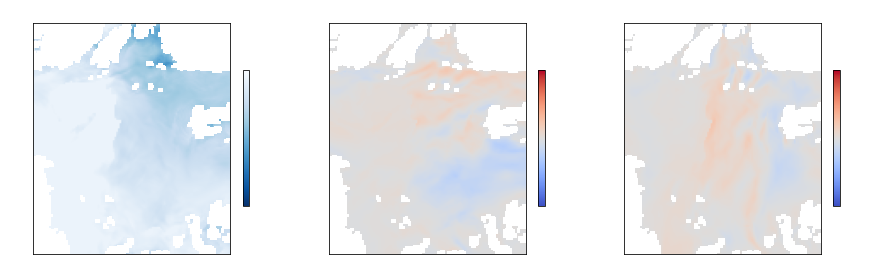

In [52]:
bc_eta, bc_hu, bc_hv = ref_baroclinic_sim.download()

fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(-bc_eta, vmin=-25, vmax=0, cmap="Blues_r")
axs[0].set_title("MLD")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(bc_hu, vmin=-5, vmax=5, cmap="coolwarm")
axs[1].set_title("hu")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(bc_hv, vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("hv")
plt.colorbar(im, ax=axs[2], shrink=0.5)

In [53]:
subt = 3600
for runt in range(int(T/subt)):
    ref_baroclinic_sim.step(subt)

#### Combined deterministic simulation with drifters

Just for reference

In [54]:
from gpuocean.SWEsimulators import CombinedCDKLM16

ref_barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=False)
ref_baroclinic_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args), dt=0.0, write_netcdf=False)

ref_sims = CombinedCDKLM16.CombinedCDKLM16(barotropic_sim=ref_barotropic_sim, baroclinic_sim=ref_baroclinic_sim)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Boknafjord/netcdf_2023_04_20/CDKLM16_2023_04_20-16_06_21.nc ...


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Boknafjord/netcdf_2023_04_20/CDKLM16_2023_04_20-16_06_28.nc ...


In [55]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [56]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': ref_sims.nx, 'ny': ref_sims.ny,
                'domain_size_x': ref_sims.nx*ref_sims.dx,
                'domain_size_y': ref_sims.ny*ref_sims.dy,
                'land_mask': ref_sims.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

In [57]:
initx = np.array([ 2500,  6000, 11000,  7500])
inity = np.array([10000,  7500,  7000, 12000])

num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(drifter_gpu_ctx, num_drifters,
                                                    boundaryConditions = ref_sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = ref_sims.gpu_stream,
                                                    wind=ref_barotropic_data_args["wind"],
                                                    wind_drift_factor=0.02/2 # halfend since drift kernel called twice
                                                    )

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

In [58]:
ref_sims.attachDrifters(drifters)
trajectories.add_observation_from_sim(ref_sims)

In [59]:
ref_sims.combinedStep(T, trajectory_dt=60, trajectories=trajectories)

(21600.0, 21600.0)

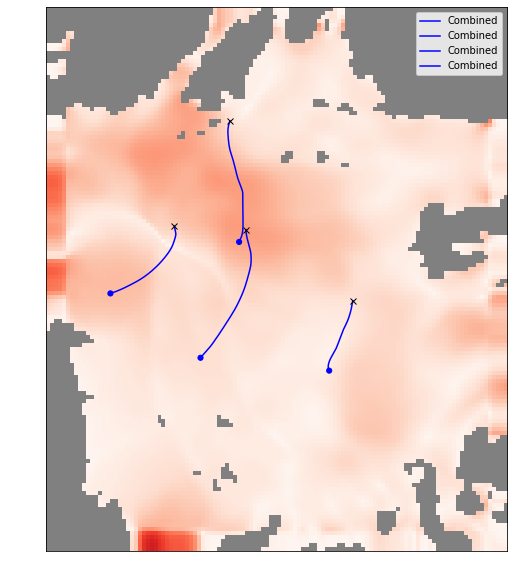

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

combined_eta, combined_u, combined_v = ref_sims.download() 
uv_field = np.sqrt(combined_u**2 + combined_v**2)


domain_extent = [0, ref_sims.nx*ref_sims.dx, 0, ref_sims.ny*ref_sims.dy]

velo_cmap = copy.deepcopy(plt.cm.Reds)
velo_cmap.set_bad("grey", alpha = 1.0)

ax.imshow(uv_field, interpolation="none", origin='lower', 
                cmap=velo_cmap, 
                vmin=0.0, vmax=0.5, 
                extent=domain_extent)

for drifter_id in range(len(initx)):
    drifter_path = trajectories.get_drifter_path(drifter_id, 0, ref_sims.t, in_km = False)[0]

    start_pos = drifter_path[0,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                    100, color = 'blue',
                                                    fill=True, zorder=10)
    ax.add_patch(circ_start)

    ax.plot(drifter_path[:,0], drifter_path[:,1], color="blue", ls="-", zorder=5, label="Combined")
    end_pos = drifter_path[-1,:]
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)


ax.legend(labelcolor="black")


## Cross Pert Drifters

The test scenario should be
- X barotropic simulations (different `wind`)
- Y wind drift factors (connected to barotropic sims, since wind response of baroclinic model is already well covered)
- Z baroclinic simulations (2 different `wind`, with 2 different `wind_stress_factors` and 3 different `g`)

In [61]:
import pandas as pd 

In [62]:
# Wind 
def rotate_wind_field(wind, angle, plot=False):
    radians = (angle/360)*2*np.pi
    wind_u = wind.wind_u.copy()
    wind_v = wind.wind_v.copy()
    t = wind.t.copy()
    #print(t)

    c = np.cos(radians)
    s = np.sin(radians)
    wind_u_new = wind_u * c - wind_v * s
    wind_v_new = wind_u * s + wind_v * c

    if plot:
        x0, x1 = 200, 220
        y0, y1 = 200, 220

        fig = plt.figure()
        plt.quiver(wind_u[3, y0:y1, x0:x1], wind_v[3, y0:y1, x0:x1])

        fig = plt.figure()
        plt.quiver(wind_u_new[3, y0:y1, x0:x1], wind_v_new[3, y0:y1, x0:x1])
    return WindStress.WindStress(t=t, wind_u=wind_u_new, wind_v=wind_v_new)
       

In [63]:
barotropic_wind_directions = np.array([-10,-5,0,5,10])
print(barotropic_wind_directions)

barotropic_wind_samples = [None]*len(barotropic_wind_directions)
for i in range(len(barotropic_wind_directions)):
    barotropic_wind_samples[i] = rotate_wind_field(ref_baroclinic_data_args["wind"], barotropic_wind_directions[i])

[-10  -5   0   5  10]


In [64]:
baroclinic_wind_directions = np.array([-10,-5,0,5,10])
print(baroclinic_wind_directions)

baroclinic_wind_samples = [None]*len(baroclinic_wind_directions)
for i in range(len(baroclinic_wind_directions)):
    baroclinic_wind_samples[i] = rotate_wind_field(ref_baroclinic_data_args["wind"], baroclinic_wind_directions[i])

[-10  -5   0   5  10]


Collect perturbations

In [65]:
barotropic_shift_times = np.arange(-6,7,6)
barotropic_time_shift_args = [None]*len(barotropic_shift_times)

for i in range(len(barotropic_shift_times)):
    timestep_indices = [list(np.arange(t_start+barotropic_shift_times[i], t_stop+1+barotropic_shift_times[i]))]
    barotropic_time_shift_args[i] = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, 
                                                                            timestep_indices=timestep_indices, 
                                                                            norkyst_data=False, land_value=5.0, download_data=False, 
                                                                            sponge_cells=sponge_cells)

In [66]:
# Mixed layer depth (MLD) 
# Can be explored coupled or decoupled with the reduced gravity constant
mld_dens_samples = np.arange(1022.75, 1023.51, 0.1)
mld_samples_data_args = [None]*len(mld_dens_samples)

for i in range(len(mld_dens_samples)):
    _, mld_samples_data_args[i] = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 
                                                                                    mld_dens_samples[i], timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)
    print(mld_samples_data_args[i]["g"])


0.016058100841077883
0.015948324691805824
0.01580542866286293
0.015666971398304985
0.015594835403988304
0.01543089807193734
0.015194768170377715
0.014906021601483346


Generate all contextes

In [67]:
bc_gpu_ctxs = []
for i in range(len(baroclinic_wind_samples)):
    bc_gpu_ctxs.append( Common.CUDAContext() )

bt_gpu_ctxs = []
for i in range(len(barotropic_wind_samples)):
    bt_gpu_ctxs.append( Common.CUDAContext() )

#### Creating simulators

In [68]:
barotropic_sims = []
bt_table = pd.DataFrame(columns=["barotropic_id", "wind_rotation_id", "time_shift_id"]).set_index("barotropic_id")

for i_w in range(len(barotropic_wind_samples)):
    for i_t in range(len(barotropic_time_shift_args)):
        data_args = copy.copy(barotropic_time_shift_args[i_t])
        data_args["wind"] = barotropic_wind_samples[i_w]
        barotropic_sims.append( CDKLM16.CDKLM16(bt_gpu_ctxs[i_w], **NetCDFInitialization.removeMetadata(data_args), dt=0.0) )

        bt_table.loc[len(bt_table)] = [i_w, i_t]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

In [69]:
bt_table

,wind_rotation_id,time_shift_id
barotropic_id,,
0,0,0
1,0,1
2,0,2
3,1,0
4,1,1
5,1,2
6,2,0
7,2,1
8,2,2


In [70]:
baroclinic_sims_per_wind = 36

In [ ]:
baroclinic_sims = []
bc_table = pd.DataFrame(columns=["baroclinic_id", "wind_angle_id", "wind_stress_factor", "friction", "mld"]).set_index("baroclinic_id")

for i_w in range(len(baroclinic_wind_samples)):
    mld_idxs = np.random.randint(low=0, high=len(mld_dens_samples), size=baroclinic_sims_per_wind)
    wind_stress_samples = np.minimum(np.maximum(0, np.random.normal(0.35,0.3, size=baroclinic_sims_per_wind)), 0.8)
    friction_samples = np.maximum(0, np.random.normal(0.0025,0.001, size=baroclinic_sims_per_wind))
    for i_other in range(baroclinic_sims_per_wind):
        baroclinic_data_args = copy.copy(mld_samples_data_args[mld_idxs[i_other]])
        baroclinic_data_args["wind"] = baroclinic_wind_samples[i_w]
        baroclinic_data_args["wind_stress_factor"] = wind_stress_samples[i_other]
        baroclinic_data_args["r"] = friction_samples[i_other]

        baroclinic_sims.append( CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0))
        
        bc_table.loc[len(bc_table.index)] = [i_w, wind_stress_samples[i_other], friction_samples[i_other], mld_idxs[i_other]]

bc_table["wind_angle_id"] = bc_table["wind_angle_id"].astype(int)

In [ ]:
baroclinic_sims = []
bc_table = pd.DataFrame(columns=["baroclinic_id", "wind_rotation_id", "wind_stress_factor_id", "friction_id", "mld_id"]).set_index("baroclinic_id")

for i_w in range(len(baroclinic_wind_samples)):
    for i_ws in range(len(wind_stress_samples)):
        for i_f in range(len(friction_samples)):
            for i_mld in range(len(mld_samples_data_args)):
                baroclinic_data_args = copy.copy(mld_samples_data_args[i_mld])
                baroclinic_data_args["wind"] = baroclinic_wind_samples[i_w]
                baroclinic_data_args["wind_stress_factor"] = wind_stress_samples[i_ws]
                baroclinic_data_args["r"] = friction_samples[i_f]

                baroclinic_sims.append( CDKLM16.CDKLM16(bc_gpu_ctxs[i_w], **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0))
                
                bc_table.loc[len(bc_table.index)] = [i_w, i_ws, i_f, i_mld]

In [ ]:
bc_table

#### Cross Product Table 

In [ ]:
ref_table = pd.DataFrame(columns=["drifter_id", "barotropic_id", "baroclinic_id", "windage_id"]).set_index("drifter_id")

In [ ]:
for bt in range(len(barotropic_sims)):
    for bc in range(len(baroclinic_sims)):
        for windage in range(len(windage_samples)):
            ref_table.loc[len(ref_table.index)] = [bt, bc, windage]

In [ ]:
ref_table

Collecting drifter and observation objects

In [ ]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [ ]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': ref_barotropic_sim.nx, 'ny': ref_barotropic_sim.ny,
                'domain_size_x': ref_barotropic_sim.nx*ref_barotropic_sim.dx,
                'domain_size_y': ref_barotropic_sim.ny*ref_barotropic_sim.dy,
                'land_mask': ref_barotropic_sim.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)


In [ ]:
crossprod_trajectories = []
for cp in range(len(ref_table)):
    crossprod_trajectories.append(copy.deepcopy(trajectories))

In [ ]:
crossprod_drifters = []
for cp in range(len(ref_table)): 
    drifters = GPUDrifterCollection.GPUDrifterCollection(bt_gpu_ctxs[bt_table.iloc[ref_table.iloc[cp].barotropic_id].wind_rotation_id], # OBS: This is used for wind drift! 
                                                    num_drifters,
                                                    boundaryConditions = ref_barotropic_sim.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sims[ref_table.iloc[cp].barotropic_id].gpu_stream, # OBS!
                                                    wind = barotropic_wind_samples[bt_table.iloc[ref_table.iloc[cp].barotropic_id].wind_rotation_id],
                                                    wind_drift_factor = windage_samples[ref_table.iloc[cp].windage_id]/2 # drift is called twice per step, but we only want one wind contribution
                                                    )           

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)
    crossprod_drifters.append(drifters)

Attach CPdrifters

In [ ]:
from itertools import compress

In [ ]:
for bt in range(len(barotropic_sims)):
    barotropic_sims[bt].attachCrossProductDrifters( 
        list(compress(crossprod_drifters, ref_table["barotropic_id"] == bt)), 
        [baroclinic_sims[i] for i in list(ref_table[ref_table["barotropic_id"] == bt].baroclinic_id)] )

Let's fan out the drifters!

In [ ]:
bc_dt = min([bc.dt for bc in baroclinic_sims])

In [ ]:
for bc in baroclinic_sims:
    bc.step(bc_dt)

In [ ]:
for bt in barotropic_sims:
    bt.step(bc_dt)

In [ ]:
for d in range(len(crossprod_drifters)):
    crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], bt.t)

In [ ]:
# while bt.t < T:
#     print(bt.t)

#     bc_dt = min([bc.dt for bc in baroclinic_sims])
#     if bt.t % 3600 != 0:
#         bc_dt = min(bc_dt, np.ceil(bt.t/3600)*3600 - bt.t)

#     for bc in baroclinic_sims:
#         bc.step(bc_dt)

#     for bt in barotropic_sims:
#         bt.step(bc_dt)

#     for d in range(len(crossprod_drifters)):
#         crossprod_trajectories[d].add_observation_from_drifters(crossprod_drifters[d], bt.t)

In [ ]:
os.makedirs("boknafjord_pickles", exist_ok=True)
for cp in range(len(crossprod_trajectories)):
    crossprod_trajectories[cp].to_pickle("boknafjord_pickles/cp_trajectory"+str(cp))


In [ ]:
STOP

## Post-Processing

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [2]:
source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"

In [3]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [4]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 801, xi_rho: 1161, eta_u: 801, xi_u: 1160, eta_v: 800, xi_v: 1161)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

In [5]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 685, dimX-360, 335, dimY-330

In [6]:
nx = (x1-x0)
ny = (y1-y0)
dx, dy = 160.0, 160.0

In [7]:
t_start = 10

In [8]:
from gpuocean.utils import Observation

In [11]:
# all_bokna_pickles = os.listdir('bokna_pickles/')
# timestamps = list(filter(lambda str: str.endswith("rand"), all_bokna_pickles))

# print(timestamps)

# crossprod_trajectories = []

# for timestamp in timestamps: 
#     for f in os.listdir('bokna_pickles/'+timestamp):
#         if f.startswith("cp_trajectory"):
#             obs= Observation.Observation()
#             obs.read_pickle('bokna_pickles/'+timestamp+'/'+ f )
#             crossprod_trajectories.append( obs )

In [9]:
timestamp = "2023-04-21T13_07_37"

crossprod_trajectories = []

for f in os.listdir('bokna_pickles/'+timestamp):
    if f.startswith("cp_trajectory"):
        obs= Observation.Observation()
        obs.read_pickle('bokna_pickles/'+timestamp+'/'+ f )
        crossprod_trajectories.append( obs )

In [10]:
# crossprod_trajectories = []

# for f in os.listdir('boknafjord_pickles/'):
#     if f.startswith("cp_trajectory"):
#         obs= Observation.Observation()
#         obs.read_pickle('boknafjord_pickles/'+ f )
#         crossprod_trajectories.append( obs )

In [11]:
len(crossprod_trajectories)

27000

In [12]:
initx = crossprod_trajectories[0].obs_df["drifter_positions"][0][:,0]
inity = crossprod_trajectories[0].obs_df["drifter_positions"][0][:,1]

In [13]:
num_drifters = len(crossprod_trajectories[0].obs_df.iloc[0].drifter_positions)
num_drifters

4

In [14]:
def plot_cp_trajectories(drifter_id, crossprod_trajectories, o_trajectories=None):
    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(7.5,7.5))#, figsize=(15,5))
        
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.set_xticks([0,5,10,15,20])
        ax.set_yticks([0,5,10,15,20])

        domain_extent = [0, (x1-x0)*dx/1000, 0, (y1-y0)*dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap, extent=domain_extent, zorder=-10)
        
        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(0, 25, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(40, 70, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e


        T = crossprod_trajectories[0].obs_df.iloc[-1].time
        dummy_path = crossprod_trajectories[0].get_drifter_path(drifter_id, 0,  T, in_km = True)[0]
        start_pos = dummy_path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.175, color = 'C1', fill=True, zorder=2)
        ax.add_patch(circ_start)      

        # Save paths to array
        num_results = len(crossprod_trajectories)
        X = np.zeros((dummy_path.shape[0], num_results))
        Y = np.zeros((dummy_path.shape[0], num_results))

        counter=0
        for path in [t.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for t in crossprod_trajectories]:
            try:
                X[:,counter] = np.minimum(np.maximum(0, path[:,0]), (x1-x0)*dx/1000)
                Y[:,counter] = np.minimum(np.maximum(0, path[:,1]), (y1-y0)*dy/1000)
                counter+=1
            except:
                pass

        # Plot paths from array
        ax.plot(X, Y, color="C0", ls="-", zorder=-4, alpha=0.05) #, rasterized=True)
        ax.scatter(X[-1,:], Y[-1, :], marker='x', color='black', s=2, linewidths=2, zorder=-3, alpha=0.1)# , rasterized=True)

        # Plot opendrift paths
        if o_trajectories is not None:
            o_T = o_trajectories[0].obs_df.iloc[-1].time # DEBUG!!!
            for opath in [ot.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for ot in o_trajectories]:
                ax.plot(opath[:,0], opath[:,1], color="C1", ls="-", zorder=1)


        plt.tight_layout()
        ax.set_rasterization_zorder(0)
        plt.savefig("bokna_figs/"+timestamp+"/CPdrift"+str(drifter_id)+"_rasterised.pdf", bbox_inches="tight", dpi=400)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  


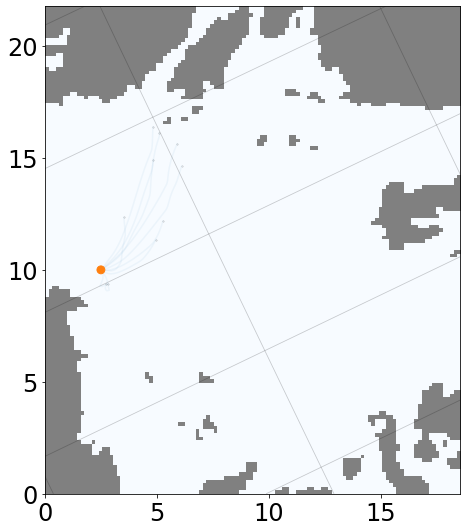

In [15]:
plot_cp_trajectories(0, crossprod_trajectories[0:10])

In [16]:
def plot_cp_kde(drifter_id, trajectories, o_trajectories=None, legend_loc=None):

    T = trajectories[0].obs_df.iloc[-1].time

    ## Get last postions
    numTrajectories = len(trajectories)

    last_positions = np.zeros((numTrajectories,2))
    for d in range(numTrajectories):
        last_positions[d] = trajectories[d].get_drifter_path(drifter_id, 0, T)[-1][-1]
    last_positions = last_positions[~np.isnan(last_positions)].reshape(-1,2)
    numTrajectories = len(last_positions)

    # Axes
    x = np.arange(nx)*dx
    y = np.arange(ny)*dy
    x/=1000
    y/=1000
    xx, yy = np.meshgrid(x,y)
    ccs = np.vstack([xx.ravel(), yy.ravel()])

    ## Kernel density estimation 
    clp = (last_positions-np.average(last_positions,axis=0)).T
    clp[0][clp[0] > (x[-1]/2)] = clp[0][clp[0] > (x[-1]/2)] - x[-1]
    clp[0][clp[0] < (-x[-1]/2)] = clp[0][clp[0] < (-x[-1]/2)] + x[-1]
    clp[1][clp[1] > (y[-1]/2)] = clp[1][clp[1] > (y[-1]/2)] - y[-1]
    clp[1][clp[1] < (-y[-1]/2)] = clp[1][clp[1] < (-y[-1]/2)] + y[-1]

    raw_cov = np.cov(clp)

    bw = 100**(-1./(2+4)) #* 0.5 #for whtatever reason scipy.stats.gaussian_kde is roughly half of that

    cov = raw_cov * bw
    covinv = np.linalg.inv(cov)

    f = np.ma.array(np.zeros((ny,nx)), mask=1-nc["mask_rho"][y0:y1,x0:x1])

    sea_mask = np.array(nc["mask_rho"][y0:y1,x0:x1], dtype=bool)
    for e in range(numTrajectories):
        d = (ccs.T-last_positions[e]).T
        d[0][d[0] > (x[-1]/2)] = d[0][d[0] > (x[-1]/2)] - x[-1]
        d[0][d[0] < (-x[-1]/2)] = d[0][d[0] < (-x[-1]/2)] + x[-1]
        d[1][d[1] > (y[-1]/2)] = d[1][d[1] > (y[-1]/2)] - y[-1]
        d[1][d[1] < (-y[-1]/2)] = d[1][d[1] < (-y[-1]/2)] + y[-1]
        temp_f = np.exp(-1/2*np.sum((d*np.dot(covinv,d)), axis=0)).reshape(ny,nx)
        temp_mass = np.sum(temp_f)
        temp_sea_mass = np.sum(temp_f[sea_mask])
        if temp_sea_mass != 0:
            f += temp_mass/temp_sea_mass * temp_f
        
    ## Levels for plotting
    fmass = np.sum(f)

    fmax = np.max(f)
    levels = np.linspace(0,fmax,100)
    level_probs = np.zeros(100)
    for l in range(len(levels)):
        level_probs[l] = np.sum(f[f>levels[l]])/fmass
    level_probs[-1] = 0.0

    desired_probs = [0.9,0.75,0.5,0.25,0.0] #descending! (ending with 0.0)
    desired_levels = np.zeros_like(desired_probs)
    for p in range(len(desired_probs)):
        desired_levels[p] = levels[np.abs(level_probs-desired_probs[p]).argmin()]
    desired_levels = np.unique(desired_levels)
    desired_levels

    with plt.rc_context({'lines.color':'black', 
                            'text.color':'black', 
                            'axes.labelcolor':'black', 
                            'xtick.color':'black',
                            'ytick.color':'black'}):
        ## Contour plots
        fig, ax = plt.subplots(1,1, figsize=(7.5,7.5))#, figsize=(15,5))
        
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.set_xticks([0,5,10,15,20])
        ax.set_yticks([0,5,10,15,20])

        domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]

        bg_cmap = copy.deepcopy(plt.cm.Blues)
        bg_cmap.set_bad("grey", alpha = 1.0)

        ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1])), interpolation="none", origin='lower', 
                        cmap=bg_cmap, extent=domain_extent)

        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(0, 25, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(40, 70, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e
        
        dummy_path = crossprod_trajectories[0].get_drifter_path(drifter_id, 0,  T, in_km = True)[0]
        start_pos = dummy_path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.175, color = 'C1', fill=True, zorder=2)
        ax.add_patch(circ_start)      

        # plotting levels and areas
        cfset = ax.contourf(xx, yy, f, levels=desired_levels, cmap='Greens', alpha=0.5)
        cset = ax.contour(xx, yy, f, levels=desired_levels, colors='k', alpha=0.25, linewidths=1)

        if legend_loc is not None:
            proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cfset.collections]
            labels = []
            for p in desired_probs:
                labels.append(str(int(p*100))+"%")
            ax.legend(proxy, labels, prop={'size': 18}, labelcolor="black", framealpha=0.9, loc=legend_loc)

        # Plot opendrift paths
        if o_trajectories is not None:    
            for opath in [ot.get_drifter_path(drifter_id, 0, T, in_km = True)[0] for ot in o_trajectories]:
                ax.plot(opath[:,0], opath[:,1], color="C1", ls="-", zorder=1)


        plt.savefig("bokna_figs/"+timestamp+"/CPkde"+str(drifter_id)+".pdf", bbox_inches="tight")


In [17]:
# for d in range(num_drifters):
#     plot_cp_kde(d, trajectories, d)

OpenDrift

In [18]:
from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
from opendrift.models.oceandrift import OceanDrift
from datetime import timedelta

import xarray as xr

In [19]:
reader = reader_ROMS_native.Reader(source_url)
reader.start_time

No proj string or projection could be derived, using 'fakeproj'. This assumes that the variables are structured and gridded approximately equidistantly on the surface (i.e. in meters). This must be guaranteed by the user. You can get rid of this warning by suppling a valid projection to the reader.


datetime.datetime(2019, 11, 1, 1, 0)

In [20]:
init_local_index_x = np.array(initx)/dx
init_local_index_y = np.array(inity)/dy

init_global_index_x = init_local_index_x + x0
init_global_index_y = init_local_index_y + y0

init_lon, init_lat = reader.xy2lonlat(init_global_index_x, init_global_index_y)

In [21]:
def opendrift_trajectories(wind_drift_factor=0.0):
    o = OceanDrift(loglevel=20)
    o.add_reader(reader)

    o.seed_elements(lat=init_lat, lon=init_lon, time=reader.start_time+ datetime.timedelta(hours=t_start), 
                    wind_drift_factor=wind_drift_factor*np.ones_like(init_lat))

    o.run(duration = datetime.timedelta(hours=6), time_step=600, time_step_output=600)

    ts = o.get_time_array()[1]
    for i in range(len(ts)):
        ts[i] = ts[i].total_seconds()
    ts = np.array(ts)

    lon, lat = o.get_lonlats()
    x,y = reader.lonlat2xy(lon,lat)

    X = (x-x0)*dx
    Y = (y-y0)*dy

    trajectories = Observation.Observation(domain_size_x=nx*dx, domain_size_y=ny*dy, nx=x1-x0, ny=y1-y0, land_mask=1-nc["mask_rho"][y0:y1,x0:x1])
    trajectories.add_observations_from_arrays(ts, X, Y)

    return trajectories

In [22]:
o_wind_drift_factors = [0.0, 0.015, 0.03]

In [23]:
o_trajectories = [opendrift_trajectories(wind_drift_factor) for wind_drift_factor in o_wind_drift_factors]

14:08:39 INFO    opendrift.models.basemodel: OpenDriftSimulation initialised (version 1.8.5)
14:08:39 INFO    opendrift.models.basemodel: Fallback values will be used for the following variables which have no readers: 
14:08:39 INFO    opendrift.models.basemodel: 	upward_sea_water_velocity: 0.000000
14:08:39 INFO    opendrift.models.basemodel: 	sea_surface_wave_significant_height: 0.000000
14:08:39 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
14:08:39 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
14:08:39 INFO    opendrift.models.basemodel: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
14:08:39 INFO    opendrift.models.basemodel: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
14:08:39 INFO    opendrift.models.basemodel: 	surface_downward_x_stress: 0.000000
14:08:39 INFO    opendrift.models.basemodel: 	surface_downward_y_stress: 0

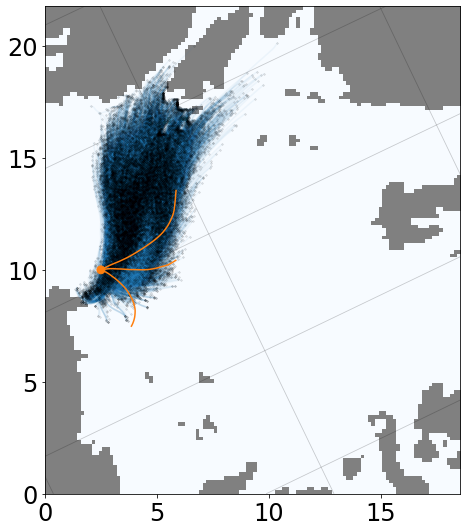

In [24]:
plot_cp_trajectories(0, crossprod_trajectories, o_trajectories)

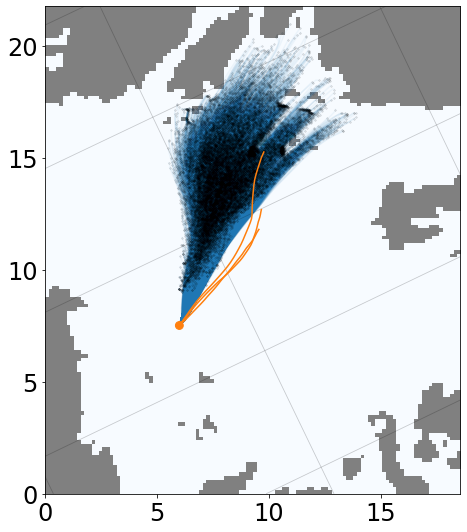

In [25]:
plot_cp_trajectories(1, crossprod_trajectories, o_trajectories)

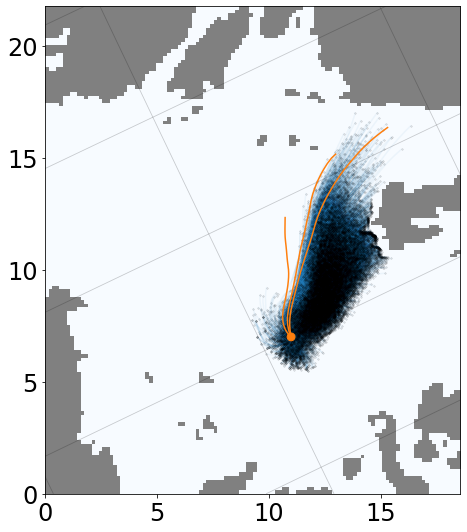

In [26]:
plot_cp_trajectories(2, crossprod_trajectories, o_trajectories)

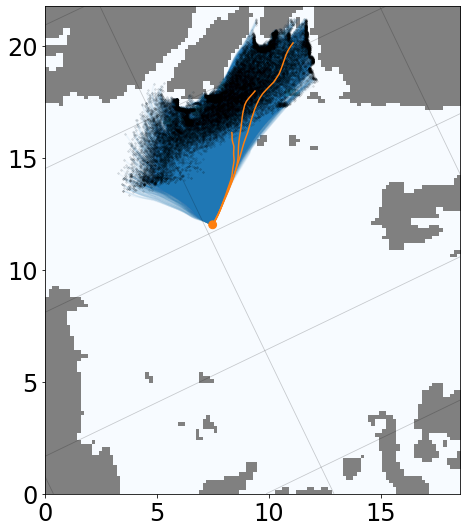

In [27]:
plot_cp_trajectories(3, crossprod_trajectories, o_trajectories)

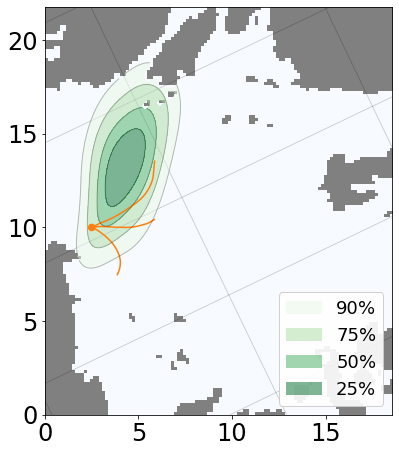

In [28]:
plot_cp_kde(0, crossprod_trajectories, o_trajectories, legend_loc=4)

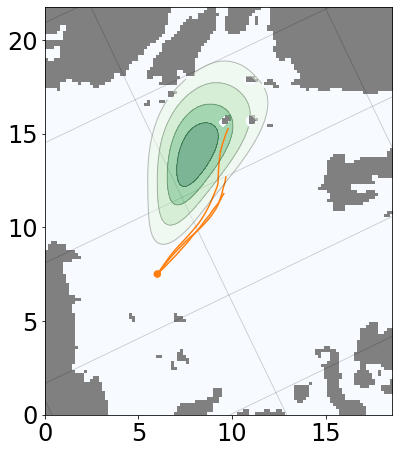

In [29]:
plot_cp_kde(1, crossprod_trajectories, o_trajectories, legend_loc=None)

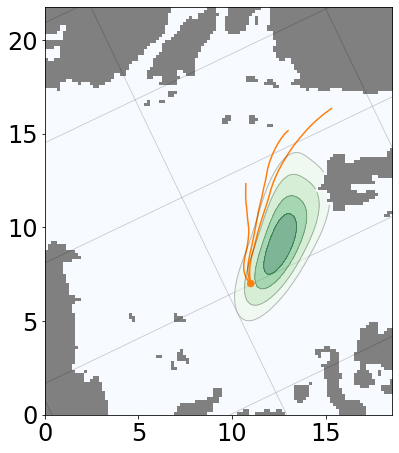

In [30]:
plot_cp_kde(2, crossprod_trajectories, o_trajectories, legend_loc=None)

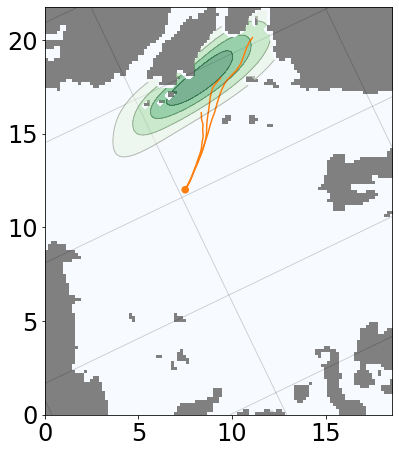

In [31]:
plot_cp_kde(3, crossprod_trajectories, o_trajectories, legend_loc=None)